The datasets in which we will be using here were obtained via open sources.

---

Let's begin with importing our needed libraries.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import json

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 50
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5);

Here, we will be using logistic regression (logistic classification). Logistic regression/classification models use elements from both the linear regression and the KNN algorithms. Let's create a model to utilize the different measurements of properties of glass that can ultimately be used to identify the glass type.

In [2]:
# Let's read in the data #
glass = pd.read_csv('./data/glass.csv')
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


**Data Dictionary**

- `RI`: Refractive index
- `(unit measurements: weight percent in corresponding oxide)`
- `Na`: Sodium
- `Mg`: Magnesium
- `Al`: Aluminum
- `Si`: Silicon
- `K`: Potassium
- `Ca`: Calcium
- `Ba`: Barium
- `Fe`: Iron
- `Type`: Type of glass

In [3]:
# Let's change the columns to something more uniform #
glass.columns = ['ri','na','mg','al','si','k','ca','ba','fe','glass_type']

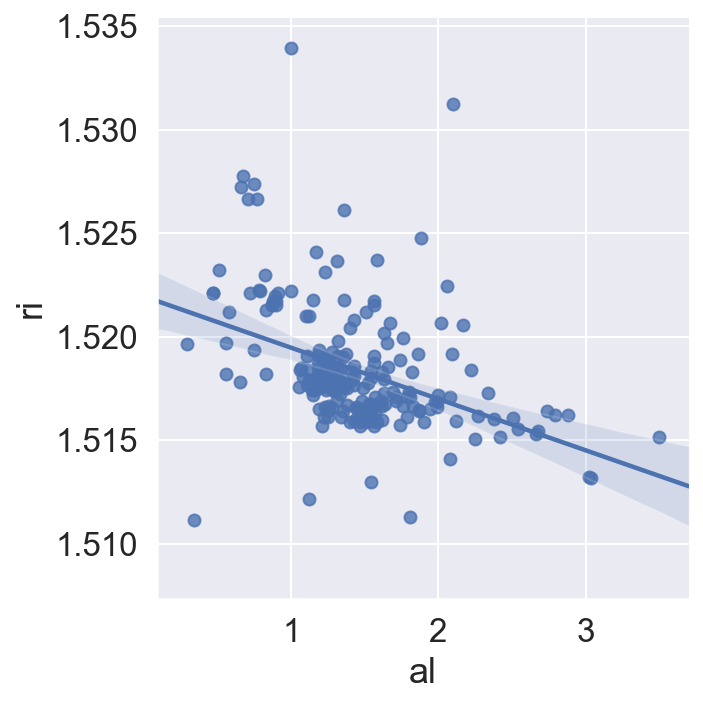

In [4]:
# Let's assume we want to predict ri only using the feature al. Let's create a quick scatter plot #
sns.lmplot(x='al', y='ri', data=glass);

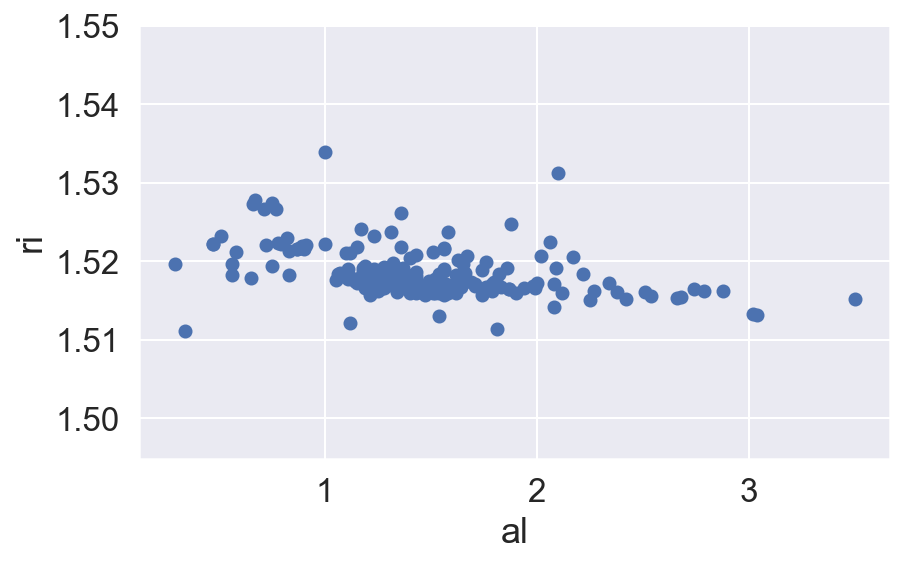

In [5]:
# Let's just take a look at the data points for now #
plt.scatter(glass.al, glass.ri);
plt.xlabel('al');
plt.ylabel('ri');

In [6]:
# Let's check how a linear regression model would fit the data #
linreg = LinearRegression()

feature_cols = ['al']
X = glass[feature_cols]
y = glass.ri

linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

linear intercept: 1.5219453302386425
linear coefficient: [-0.00247761]


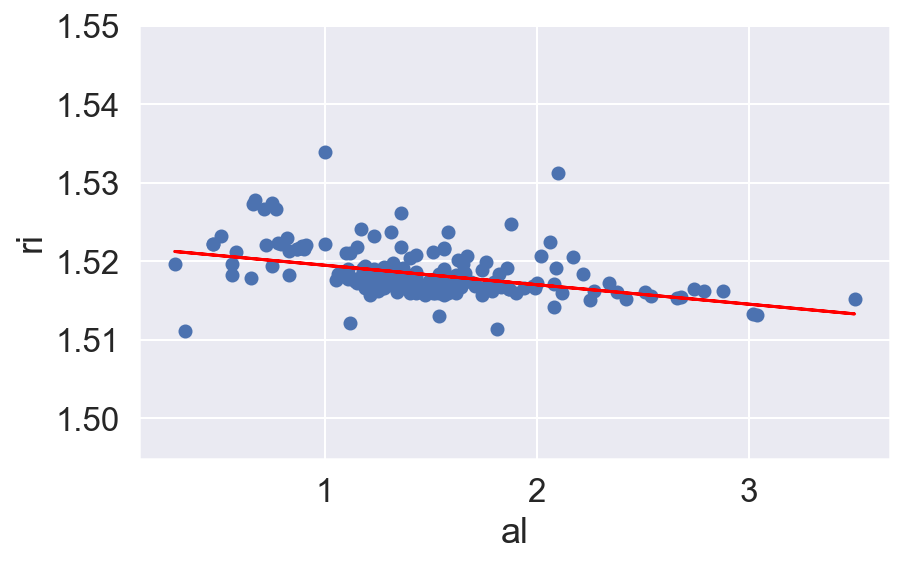

In [7]:
# Let's use the linear regression model to make predictions and compare it to the original data #
y_pred = linreg.predict(X)
glass['y_pred'] = y_pred

plt.scatter(glass.al, glass.ri);
plt.plot(glass.al, glass.y_pred, color='red');
plt.xlabel('al');
plt.ylabel('ri');
print('linear intercept:',linreg.intercept_)
print('linear coefficient:',linreg.coef_)

We can see that linear regression is appropriate when we want to predict the value of a continuous target/response variable, but what about when we want to predict membership in a class or category?

In [8]:
# Let's check out the glass_type feature #
glass.glass_type.value_counts().sort_index()

1    70
2    76
3    17
5    13
6     9
7    29
Name: glass_type, dtype: int64

Let's assume that these types are subdivisions of broader glass types:

> **Window glass:** types 1, 2, and 3

> **Household glass:** types 5, 6, and 7

In [9]:
# Let's create a new household column that indicates whether or not a row is household glass #
glass['household'] = glass.glass_type.map({1:0, 2:0, 3:0, 5:1, 6:1, 7:1})
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,y_pred,household
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1,1.519220,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1,1.518576,0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1,1.518130,0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1,1.518749,0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1,1.518873,0


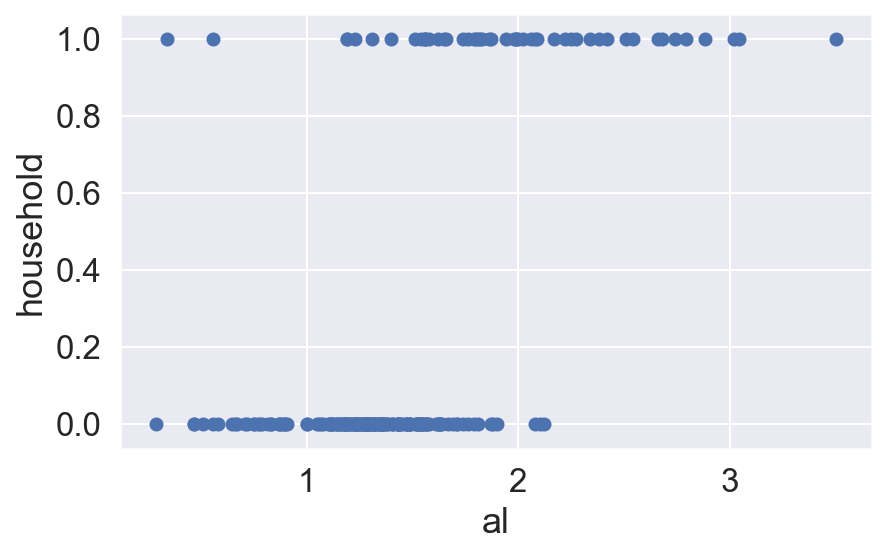

In [10]:
# Now, let's assume that we're predicting the household category using al #
plt.scatter(glass.al, glass.household);
plt.xlabel('al');
plt.ylabel('household');

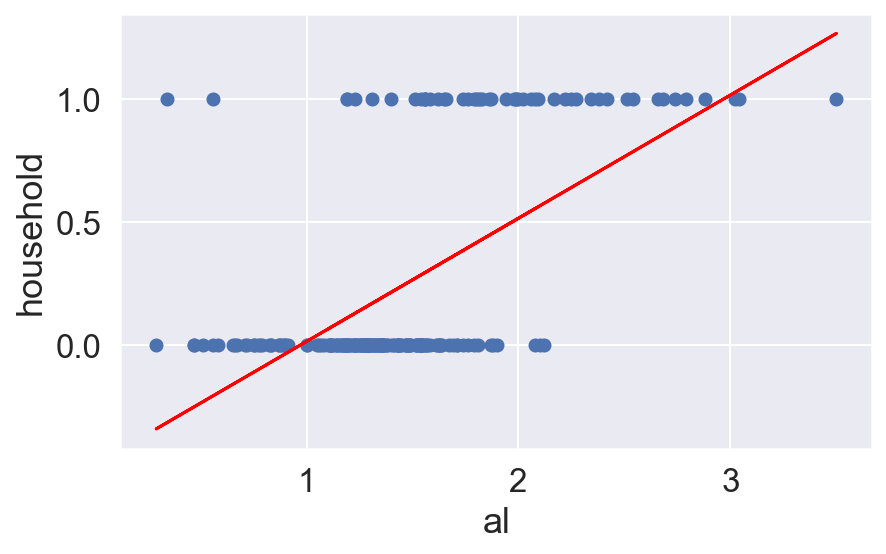

In [11]:
# Like before, let's fit a linear regression model to make predictions and compare it to the original data #
feature_cols = ['al']
X = glass[feature_cols] 
y = glass.household 
linreg.fit(X, y)
glass['household_pred'] = linreg.predict(X)

plt.scatter(glass.al, glass.household);
plt.plot(glass.al, glass.household_pred, color='red');
plt.xlabel('al');
plt.ylabel('household');

We can see above that the linear regression model isn't really useful since our dataset isn't continuous. We need a threshold to differentiate the categories. Let's create a new column of our predictions for whether a row is considered household glass.

In [12]:
# Let's transform household_pred to 1 or 0 #
glass['household_pred_class'] = np.where(glass.household_pred >= 0.5, 1, 0)
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,y_pred,household,household_pred,household_pred_class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1,1.519220,0,0.065459,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1,1.518576,0,0.195765,0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1,1.518130,0,0.285976,0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1,1.518749,0,0.160682,0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1,1.518873,0,0.135623,0


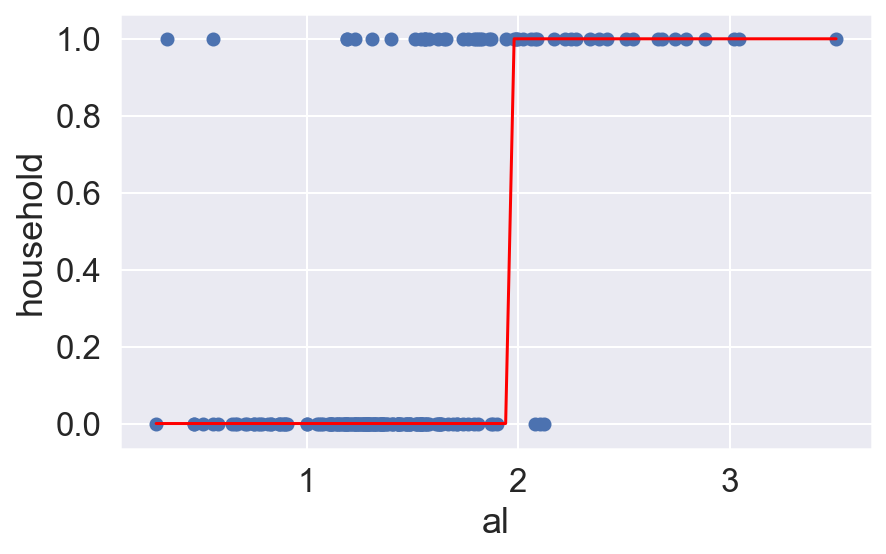

In [13]:
# Let's sort the data values so we can have a continuous line #
glass.sort_values('al', inplace=True)

# Now, let's plot the class predictions #
plt.scatter(glass.al, glass.household);

plt.xlabel('al');
plt.ylabel('household');

plt.plot(glass.al, glass.household_pred_class, color='red');

Logistic regression is a more appropriate method for what we just did with the linear regression model above. This is because the values output from a linear regression cannot be interpreted as probabilities of class membership since their values can be greater than 1 and less than 0. However, logistic regression ensures that the values output as predictions; which can be interpreted as probabilities of class membership. Let's continue with a logistic regression model.

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


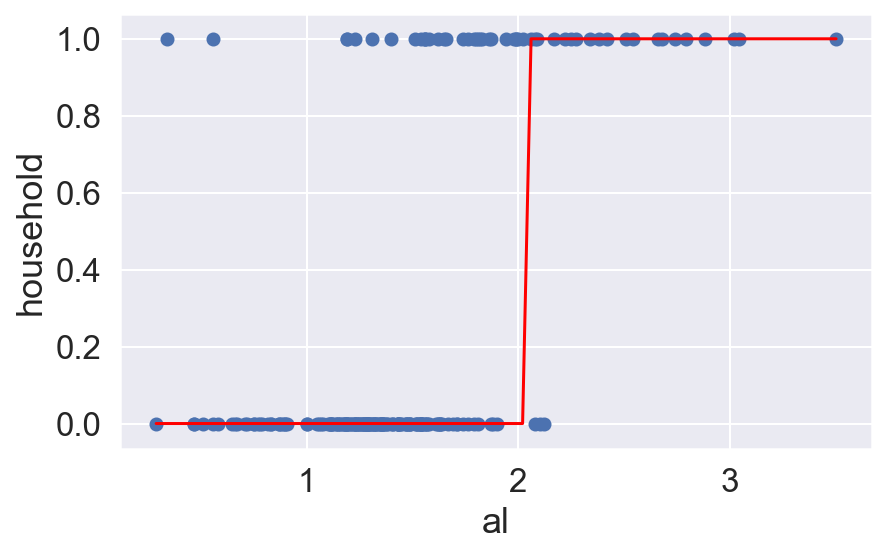

In [14]:
# Let's fit a logistic regression model to make predictions and compare it to the original data #
logreg = LogisticRegression()

feature_cols = ['al']
X = glass[feature_cols]
y = glass.household

logreg.fit(X,y)
pred = logreg.predict(X)

plt.scatter(glass.al, glass.household);
plt.plot(glass.al, pred, color='red');
plt.xlabel('al');
plt.ylabel('household');

In [15]:
# We can also check the predicted probabilities to see how confident we are in a given prediction #
logreg.predict_proba(X)[0:10]

array([[0.97193375, 0.02806625],
       [0.96905681, 0.03094319],
       [0.96017962, 0.03982038],
       [0.96017962, 0.03982038],
       [0.9569876 , 0.0430124 ],
       [0.95265323, 0.04734677],
       [0.95265323, 0.04734677],
       [0.95080573, 0.04919427],
       [0.94378757, 0.05621243],
       [0.94271112, 0.05728888]])

In [16]:
# Let's store the predicted probabilities of class 1 #
glass['household_pred_prob'] = logreg.predict_proba(X)[:, 1]

glass.sample(10)

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,y_pred,household,household_pred,household_pred_class,household_pred_prob
41,1.51755,12.71,3.42,1.20,73.20,0.59,8.64,0.00,0.00,1,1.518972,0,0.115576,0,0.152553
93,1.51590,13.24,3.34,1.47,73.10,0.39,8.22,0.00,0.00,2,1.518303,0,0.250894,0,0.236539
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.00,0.11,1,1.518576,0,0.195765,0,0.198936
48,1.52223,13.21,3.77,0.79,71.99,0.13,10.02,0.00,0.00,1,1.519988,0,-0.089906,0,0.073154
113,1.51892,13.46,3.83,1.26,72.55,0.57,8.21,0.00,0.14,2,1.518824,0,0.145647,0,0.168814
101,1.51730,12.35,2.72,1.63,72.87,0.70,9.23,0.00,0.00,2,1.517907,0,0.331082,0,0.299435
137,1.51711,12.89,3.62,1.57,72.96,0.61,8.11,0.00,0.00,2,1.518055,0,0.301012,0,0.274751
185,1.51131,13.69,3.20,1.81,72.81,1.76,5.43,1.19,0.00,7,1.517461,1,0.421294,0,0.380362
176,1.51905,14.00,2.39,1.56,72.37,0.00,9.57,0.00,0.00,6,1.518080,1,0.296000,0,0.270762
98,1.51689,12.67,2.88,1.71,73.21,0.73,8.54,0.00,0.00,2,1.517709,0,0.371177,0,0.334230


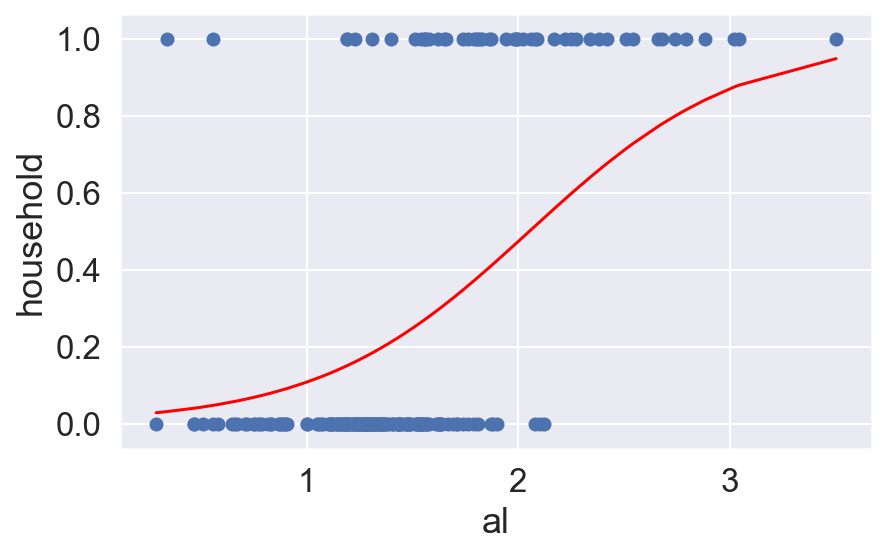

In [17]:
# Let's plot the predicted probabilities #
plt.scatter(glass.al, glass.household);
plt.plot(glass.al, glass.household_pred_prob, color='red');
plt.xlabel('al');
plt.ylabel('household');

Let's create a logistic regression model and train it using two features to predict the glass type. 

In [18]:
LR = LogisticRegression()
X = glass[['na','fe']]
y = glass.household

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

LR.fit(X_train,y_train)

y_pred = LR.predict(X_test)

print('accuracy:',LR.score(X_test, y_test))

accuracy: 0.7962962962962963


C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Let's continue practicing with logistic regression on bank marketing data. Our goal is to predict whether a customer will purchase a bank product marketed over the phone.

In [19]:
# Let's read in the data #
bank = pd.read_csv('./data/bank.csv')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


** Note: target '`y`' represented as such**
    - No : 0
    - Yes : 1

In [20]:
# Let's check the value counts of y #
bank['y'].value_counts()

0    3668
1     451
Name: y, dtype: int64

In [21]:
# Let's take about 6 randomly chosen features and build two separate models #
features = ['age','job','marital','education','contact','day_of_week','y']

for feat in features:
    if feat != 'age':
        print(bank[feat].value_counts())

admin.           1012
blue-collar       884
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
unknown            39
Name: job, dtype: int64
married     2509
single      1153
divorced     446
unknown       11
Name: marital, dtype: int64
university.degree      1264
high.school             921
basic.9y                574
professional.course     535
basic.4y                429
basic.6y                228
unknown                 167
illiterate                1
Name: education, dtype: int64
cellular     2652
telephone    1467
Name: contact, dtype: int64
thu    860
mon    855
tue    841
wed    795
fri    768
Name: day_of_week, dtype: int64
0    3668
1     451
Name: y, dtype: int64


Note: We have some unknown values in education, marital and employment. We can make some assumptions but given the relatively small counts, we will choose to drop the unknowns as we do not want to encorporate any additional bias into the data itself.

In [22]:
# Let's create the sub dataframe with only the features we're using #
bank_a =  bank[features]

# Let's also drop the unknowns within our chosen features #
bank_a = bank_a[bank_a['education'] != 'unknown']
bank_a = bank_a[bank_a['job'] != 'unknown']
bank_a = bank_a[bank_a['marital'] != 'unknown']

Let's build the first model using the features age, job, education, and day_of_week.

In [23]:
# Let's create dummy variables #
bank_md1 = pd.get_dummies(bank_a[['age','job','education','day_of_week','y']], drop_first = True)

# Let's instantiate the model #
LogReg1 = LogisticRegression()

# Let's secure our X and y features #
X1 = bank_md1.drop('y', axis =1)
y1 = bank_md1['y']

# Let's use train test split to cross validate #
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1,y1, random_state=42)

# Now, let's fit the model #
LogReg1.fit(x_train1, y_train1)

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
# Let's get the coefficient values for each feature used #
name = bank_md1.columns.drop('y')

coef = LogReg1.coef_[0]

pd.DataFrame([name,coef],index = ['Name','Coef']).transpose()

,Name,Coef
0,age,0.00762961
1,job_blue-collar,-0.426391
2,job_entrepreneur,-1.49324
3,job_housemaid,-0.444983
4,job_management,-0.426168
5,job_retired,0.608415
6,job_self-employed,-0.330618
7,job_services,-0.405957
8,job_student,0.904477
9,job_technician,-0.0304069


In [25]:
# Let's make predictions with the model and check the accuracy #
y_pred = LogReg1.predict(x_test1)
baseline = 1. - bank_md1.y.mean()
print('baseline:',baseline)
print('accuracy:',metrics.accuracy_score(y_test1,y_pred))

baseline: 0.8922094508301405
accuracy: 0.898876404494382


In [26]:
# Let's create a confusion matrix #
metrics.confusion_matrix(y_test1,y_pred)

array([[880,   0],
       [ 99,   0]], dtype=int64)

In [27]:
# Let's check AUROC #
metrics.roc_auc_score(y_test1,y_pred)

0.5

In [28]:
# Let's check log loss #
metrics.log_loss(y_test1,y_pred)

3.492685253417935

We can see that our accuracy looks great at first. However, against the baseline, this accuracy is barely better than the baseline and such an insignificant difference could just be from how our train test split groupped the data. Furthermore, when looking at the confusion matrix above, it seems like we have 880 true negatives and 99 false negatives; which indicates that the model might just be predicting 'no' everytime. We can also observe the Area Under the ROC Curve is 0.5, which is worthless and states that our model gains no more insight than random guessing. Let's continue with our second model.

In [29]:
# Let's create dummy variables #
bank_md2 = pd.get_dummies(bank_a, drop_first = True)

# Let's instantiate the model #
LogReg2 = LogisticRegression()

# Let's secure our X and y features #
X2 = bank_md2.drop('y', axis =1)
y2 = bank_md2['y']

# Let's use train test split to cross validate #
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2,y2, random_state=42)

# Now, let's fit the model #
LogReg2.fit(x_train2, y_train2)

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
# Let's get the coefficient values for each feature used #
name = bank_md2.columns.drop('y')

coef = LogReg2.coef_[0]

pd.DataFrame([name,coef],index = ['Name','Coef']).transpose()

,Name,Coef
0,age,0.0143316
1,job_blue-collar,-0.345223
2,job_entrepreneur,-1.39848
3,job_housemaid,-0.384801
4,job_management,-0.394074
5,job_retired,0.472354
6,job_self-employed,-0.289769
7,job_services,-0.318289
8,job_student,0.809601
9,job_technician,-0.0412194


In [31]:
# Let's make predictions with the model and check the accuracy #
y_pred2 = LogReg2.predict(x_test2)
baseline = 1. - bank_md2.y.mean()
print('baseline:',baseline)
print('accuracy:',metrics.accuracy_score(y_test2,y_pred2))

baseline: 0.8922094508301405
accuracy: 0.898876404494382


In [32]:
# Let's create a confusion matrix #
metrics.confusion_matrix(y_test2,y_pred2)

array([[880,   0],
       [ 99,   0]], dtype=int64)

In [33]:
# Let's check AUROC #
metrics.roc_auc_score(y_test2,y_pred2)

0.5

In [34]:
# Let's check log loss #
metrics.log_loss(y_test2,y_pred2)

3.492685253417935

We can see that none of the metrics really changed. Thus, the features we chose aren't very helpful. However, before we revert to grabbing more features, let's attempt adjusting the probability threshold.

In [35]:
# Let's check the predicted probabilities #
y_pred_prob = LogReg2.predict_proba(x_test2)

y_pred_prob

array([[0.81582351, 0.18417649],
       [0.93532482, 0.06467518],
       [0.81732417, 0.18267583],
       ...,
       [0.82688588, 0.17311412],
       [0.95322693, 0.04677307],
       [0.89817216, 0.10182784]])

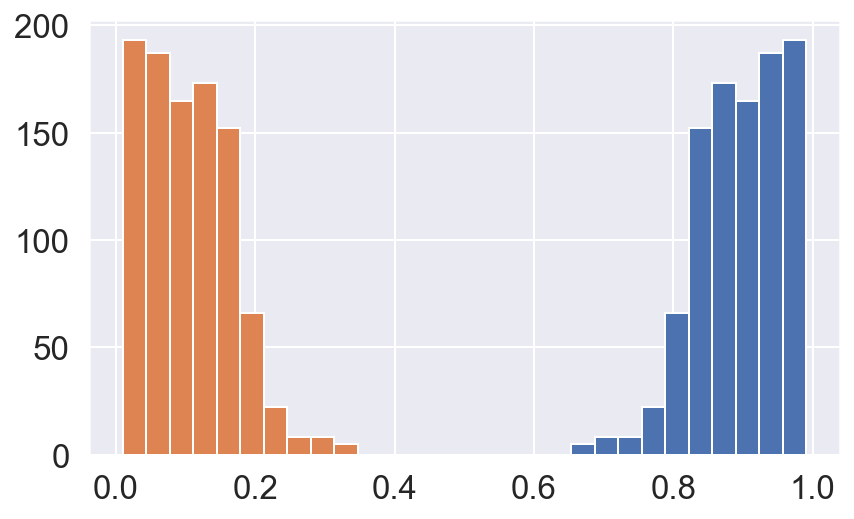

In [36]:
# Let's plot the predicted probabilities #
y_pred_prob_t = y_pred_prob.transpose()

plt.hist(y_pred_prob_t[0]);
plt.hist(y_pred_prob_t[1]);
plt.show();

In [37]:
# Let's try decreaseing the threshold to 20% predicted probability or higher #
y_pred3 = []

for prob in y_pred_prob_t[1]:
    if prob > .20:
        y_pred3.append(1)
    else:
        y_pred3.append(0)
        
print(len(y_pred3))
print(len(y_test2))

979
979


In [38]:
# Let's make predictions with the model and check the accuracy #
baseline = 1. - bank_md2.y.mean()
print('baseline:',baseline)
print('accuracy:',metrics.accuracy_score(y_test2,y_pred3))

baseline: 0.8922094508301405
accuracy: 0.8610827374872319


In [39]:
# Let's create a confusion matrix #
metrics.confusion_matrix(y_test2,y_pred3)

array([[834,  46],
       [ 90,   9]], dtype=int64)

In [40]:
# Let's check AUROC #
metrics.roc_auc_score(y_test2,y_pred3)

0.5193181818181818

In [41]:
# Let's check log loss #
metrics.log_loss(y_test2,y_pred3)

4.798069837783086

It seems that we have not improved the model at all. Let's attempt creating a model using all of the features.

In [42]:
# Let's create dummy variables #
bank_all = pd.get_dummies(bank, drop_first = True)

# Let's instantiate the model #
LogReg3 = LogisticRegression(penalty='l1',C=0.01)

# Let's secure our X and y features #
X3 = bank_all.drop('y', axis =1)
y3 = bank_all['y']

# Let's use train test split to cross validate #
x_train3, x_test3, y_train3, y_test3 = train_test_split(X3,y3, random_state=42)

# Now, let's fit the model #
LogReg3.fit(x_train3, y_train3)

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
# Let's get the coefficient values for each feature used #
name = bank_all.columns.drop('y')

coef = LogReg3.coef_[0]

pd.DataFrame([name,coef],index = ['Name','Coef']).transpose()

,Name,Coef
0,age,0.0032553
1,duration,0.00473063
2,campaign,0
3,pdays,-0.00210373
4,previous,0
5,emp.var.rate,0
6,cons.price.idx,0.0336524
7,cons.conf.idx,0.0350729
8,euribor3m,-0.398526
9,nr.employed,-0.000469966


In [44]:
# Let's make predictions with the model and check the accuracy #
y_pred3 = LogReg3.predict(x_test3)
baseline = 1. - bank_all.y.mean()
print('baseline:',baseline)
print('accuracy:',metrics.accuracy_score(y_test3,y_pred3))

baseline: 0.8905074047098811
accuracy: 0.9087378640776699


In [45]:
# Let's create a confusion matrix #
metrics.confusion_matrix(y_test3, y_pred3)

array([[895,  26],
       [ 68,  41]], dtype=int64)

In [46]:
# Let's check AUROC #
metrics.roc_auc_score(y_test3, y_pred3)

0.6739583022044248

In [47]:
# Let's check log loss #
metrics.log_loss(y_test3,y_pred3)

3.152102689956106

Let's try regularization to optimize our model.

In [48]:
# Let's secure our X and y features #
X = bank_all.drop('y', axis =1)
y = bank_all['y']

# Let's use train test split to cross validate #
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=42)

# Create loop to find best AUROC given regularization (c) value #
cees = [0.01, 0.1, 1.0, 10, 100]

for c in cees:
    logreg = LogisticRegression(penalty='l1', C=c)
    logreg.fit(x_train,y_train)
    y_pred = logreg.predict(x_test)
    roc = metrics.roc_auc_score(y_test, y_pred)
    print('AUROC:',roc,'for C =',c)

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUROC: 0.6739583022044248 for C = 0.01


C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUROC: 0.6815039496359163 for C = 0.1
AUROC: 0.6971381326639373 for C = 1.0


C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUROC: 0.6947225293607866 for C = 10
AUROC: 0.6947225293607866 for C = 100


In [49]:
# Create loop to find best AUROC given regularization (c) value #
cees = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7 ,1.8, 1.9]

for c in cees:
    logreg = LogisticRegression(penalty='l1', C=c)
    logreg.fit(x_train,y_train)
    y_pred = logreg.predict(x_test)
    roc = metrics.roc_auc_score(y_test, y_pred)
    print('AUROC:',roc,'for C =',c)

AUROC: 0.6965952444988993 for C = 1.1


C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUROC: 0.6976810208289753 for C = 1.2


C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUROC: 0.6976810208289753 for C = 1.3


C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUROC: 0.6976810208289753 for C = 1.4
AUROC: 0.6965952444988993 for C = 1.5


C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUROC: 0.6976810208289753 for C = 1.6
AUROC: 0.6971381326639373 for C = 1.7
AUROC: 0.6971381326639373 for C = 1.8
AUROC: 0.6971381326639373 for C = 1.9


C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Let's continue practicing logistic regression to predict "greenness" of content using a dataset from a web page recommender (stumbleupon). A description of the columns are provided below.

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

**Note:** The `boilerplate` column is in json dictionary format.

In [50]:
# Let's read in the data #
evergreen_tsv = './data/evergreen_sites.tsv'
data = pd.read_csv(evergreen_tsv, sep='\t', na_values={'is_news' : '?'}).fillna(0)

# Let's extract the title and body from the boilerplate JSON text #
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

data[['title', 'label']].head()

,title,label
0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",0
1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",1
2,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,1
3,10 Foolproof Tips for Better Sleep,1
4,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,0


Does being a news site affect green-ness?

            label
is_news          
0.0      0.507562
1.0      0.516916


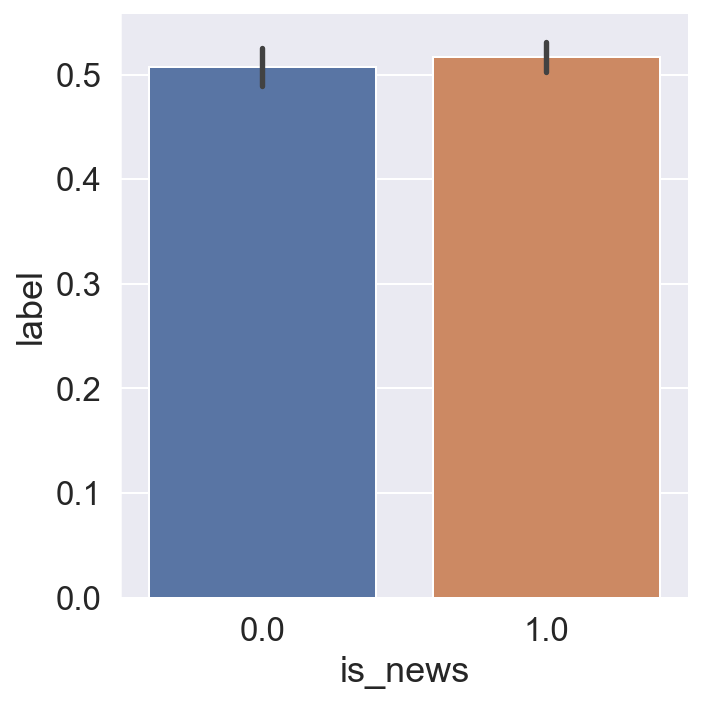

In [51]:
# Let's visualize #
sns.catplot(x='is_news', y='label', data=data, kind='bar')
print((data.groupby('is_news')[['label']].mean()))

In [52]:
# Let's do logistic regression using statsmodels #
news_data = data[['label','is_news']]

news_model = sm.logit("label ~ is_news", data=news_data).fit()
news_model.summary()

Optimization terminated successfully.
         Current function value: 0.692751
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7393
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 Apr 2020   Pseudo R-squ.:               5.980e-05
Time:                        17:48:42   Log-Likelihood:                -5122.9
converged:                       True   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                    0.4337
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0303      0.038      0.806      0.420      -0.043       0.104
is_news        0.0374      0.048      0.783      0.434      -0.056       0.131
==============================================================================
"""

Given above, we can concluded that the effect of being a news site on evergreen status is insignificant (Log-Likelihood vs LL-Null). We can accept the null hypothesis that news sites and non-news sites have equal probability of being evergreen. Does the website category affect green-ness?

In [53]:
# "Unknown" and "?" should be the same category #
data['alchemy_category'] = data.alchemy_category.map(lambda x: 'unknown' if x == '?' else x)

                       label
alchemy_category            
arts_entertainment  0.371945
business            0.711364
computer_internet   0.246622
culture_politics    0.457726
gaming              0.368421
health              0.573123
law_crime           0.419355
recreation          0.684296
religion            0.416667
science_technology  0.456747
sports              0.205263
unknown             0.501704
weather             0.000000


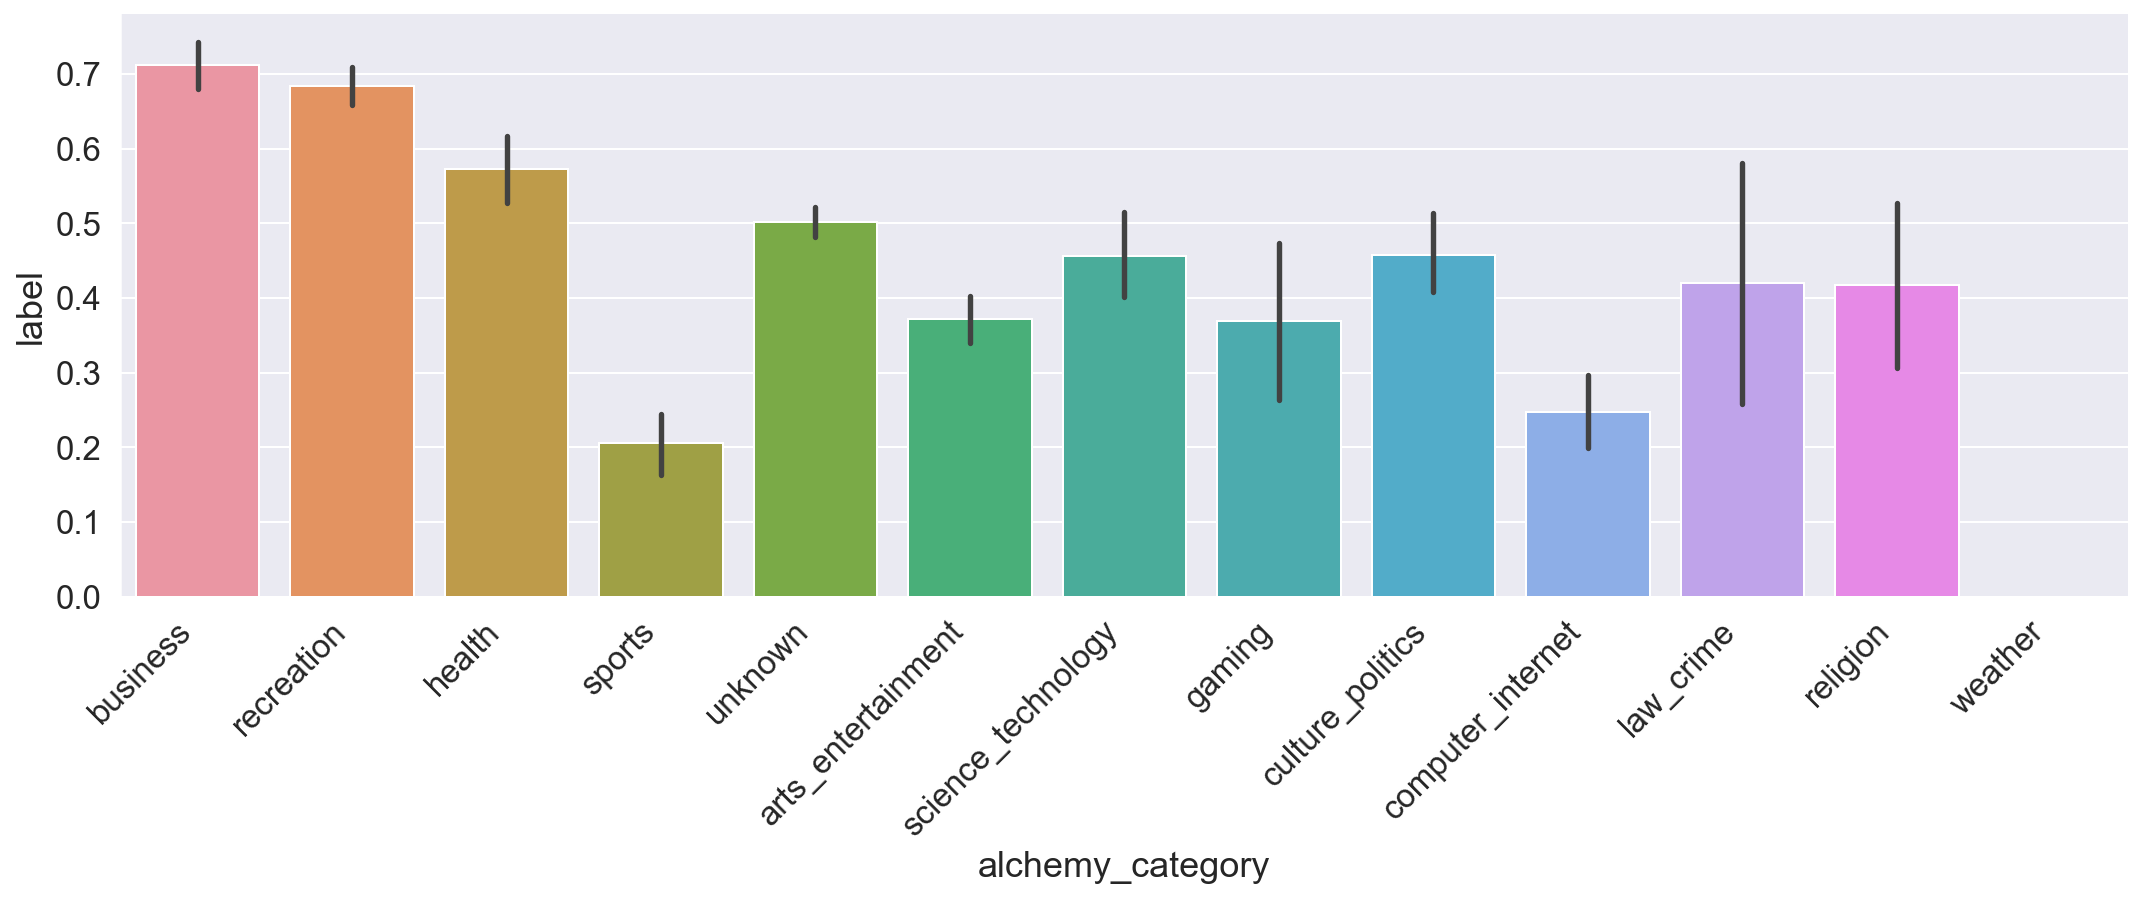

In [54]:
# Now, let's visualize #
sns.catplot(x='alchemy_category', y='label', 
               data=data, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right');

print((data.groupby('alchemy_category')[['label']].mean()))

In [55]:
# Let's do logistic regression using statsmodels #
cat_model = sm.logit("label ~ C(alchemy_category, Treatment(reference='unknown'))", data=data).fit()
cat_model.summary()

         Current function value: 0.649499
         Iterations: 35


C:\Users\Daniel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7382
Method:                           MLE   Df Model:                           12
Date:                Thu, 23 Apr 2020   Pseudo R-squ.:                 0.06249
Time:                        17:48:43   Log-Likelihood:                -4803.0
converged:                      False   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                2.585e-129
=============================================================================================================================================
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     0.0068      0.041      0.165      0.869      -0.074       0.088
C(alchemy_category, Treatment(reference='unknown'))[T.arts_entertainment]    -0.5307      0.079     -6.711      0.000      -0.686      -0.376
C(alchemy_category, Treatment(reference='unknown'))[T.business]               0.8952      0.085     10.522      0.000       0.728       1.062
C(alchemy_category, Treatment(reference='unknown'))[T.computer_internet]     -1.1235      0.141     -7.967      0.000      -1.400      -0.847
C(alchemy_category, Treatment(reference='unknown'))[T.culture_politics]      -0.1763      0.116     -1.520      0.128      -0.404       0.051
C(alchemy_category, Treatment(reference='unknown'))[T.gaming]                -0.5458      0.241     -2.261      0.024      -1.019      -0.073
C(alchemy_category, Treatment(reference='unknown'))[T.health]                 0.2878      0.099      2.910      0.004       0.094       0.482
C(alchemy_category, Treatment(reference='unknown'))[T.law_crime]             -0.3322      0.366     -0.907      0.364      -1.050       0.386
C(alchemy_category, Treatment(reference='unknown'))[T.recreation]             0.7668      0.074     10.367      0.000       0.622       0.912
C(alchemy_category, Treatment(reference='unknown'))[T.religion]              -0.3433      0.243     -1.415      0.157      -0.819       0.132
C(alchemy_category, Treatment(reference='unknown'))[T.science_technology]    -0.1803      0.125     -1.441      0.150      -0.425       0.065
C(alchemy_category, Treatment(reference='unknown'))[T.sports]                -1.3605      0.134    -10.188      0.000      -1.622      -1.099
C(alchemy_category, Treatment(reference='unknown'))[T.weather]              -18.1406   4331.829     -0.004      0.997   -8508.369    8472.087
=============================================================================================================================================
"""

Given above, we can concluded that many of the categories appear to have a significant effect on the likelihood of evergreen status. Note that we set the reference category to be unknown. This is wrapped into the intercept term. These categories must be interpreted as significantly different from unknown or not.

Positive predictors of evergreen vs. unknown:
1. Business
2. Health
3. Recreation

Negative predictors of evergreen vs. unkown:
1. Arts and entertainment
2. Computer and internet
3. Gaming
4. Sports

The rest of the categories are not significantly different than the unkown category in their probability of being evergreen or not. Does the image ratio affect green-ness?

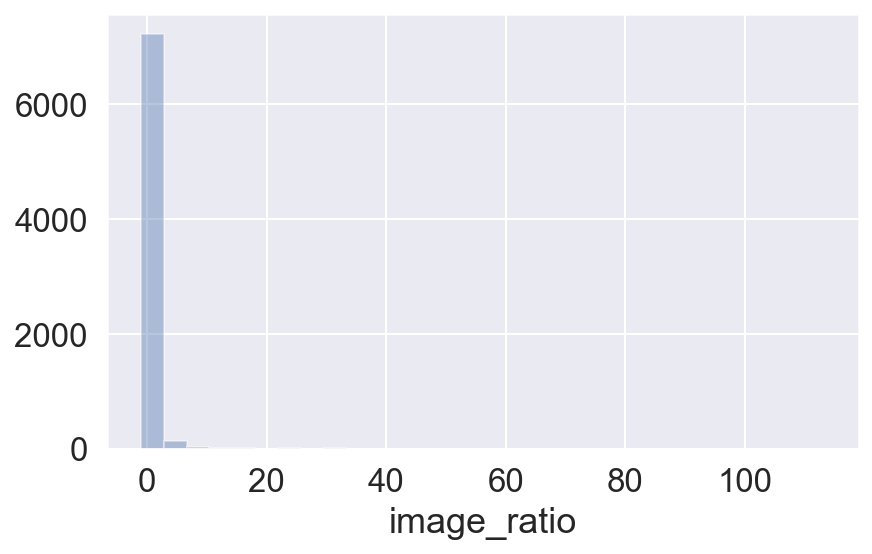

In [56]:
# Let's visualize #
sns.distplot(data.image_ratio, bins=30, kde=False);

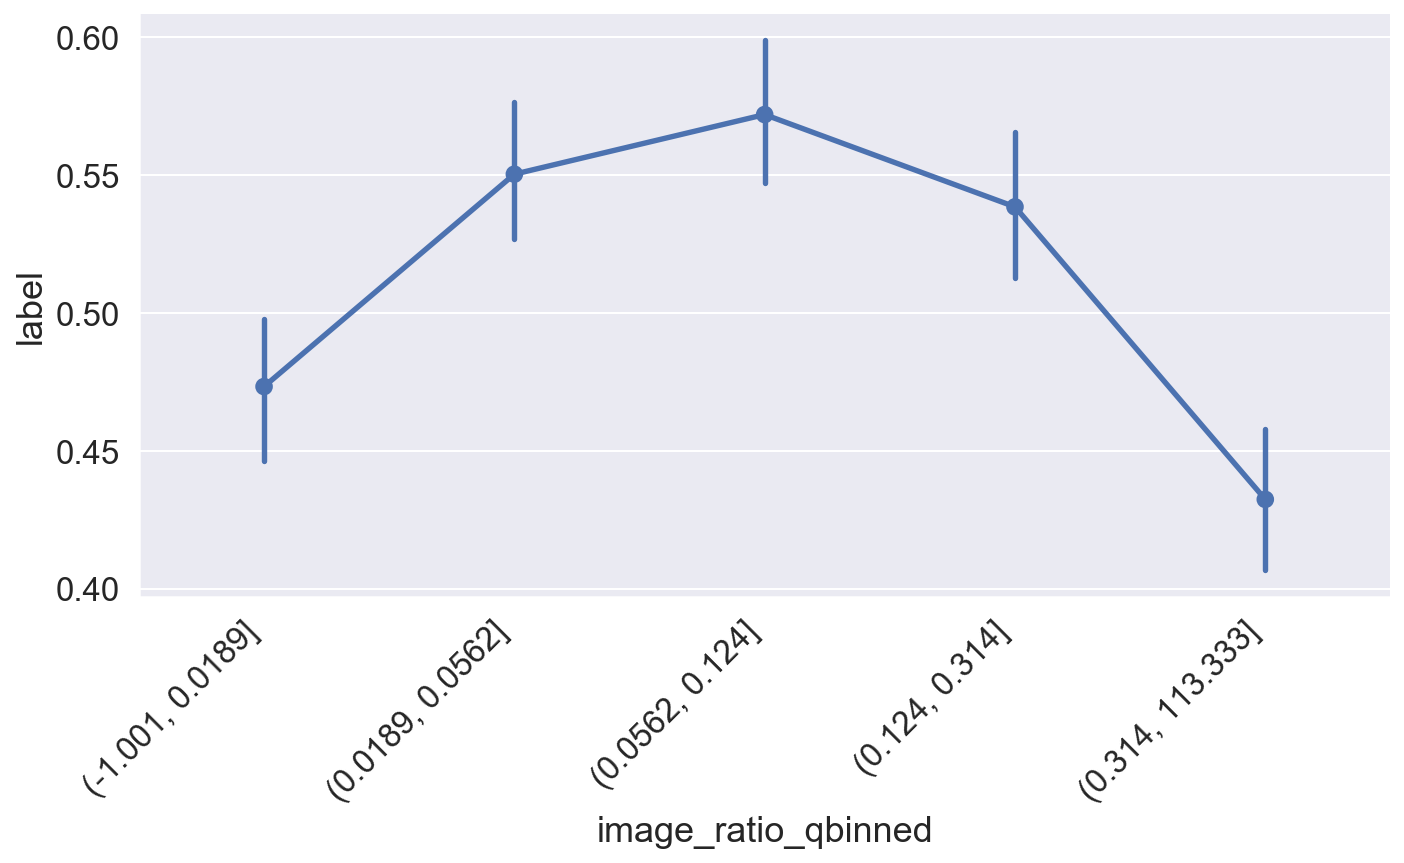

In [57]:
# Let's divide things by quantile #
data['image_ratio_qbinned'] = pd.qcut(data['image_ratio'], 5)

sns.catplot('image_ratio_qbinned', 'label', data=data, kind='point', aspect=2).set_xticklabels(rotation=45, 
                                                                                  horizontalalignment='right');

In [58]:
# Let's do logistic regression using statsmodels #
image_model = sm.logit("label ~ image_ratio", data=data).fit()
image_model.summary()

Optimization terminated successfully.
         Current function value: 0.692631
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7393
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 Apr 2020   Pseudo R-squ.:               0.0002325
Time:                        17:48:44   Log-Likelihood:                -5122.0
converged:                       True   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                    0.1228
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0590      0.024      2.499      0.012       0.013       0.105
image_ratio    -0.0210      0.015     -1.400      0.161      -0.051       0.008
===============================================================================
"""

In [59]:
# Let's convert the image ratio to percentiles #
data['image_ratio_pctl'] = data.image_ratio.map(lambda x: stats.percentileofscore(data.image_ratio.values, x))

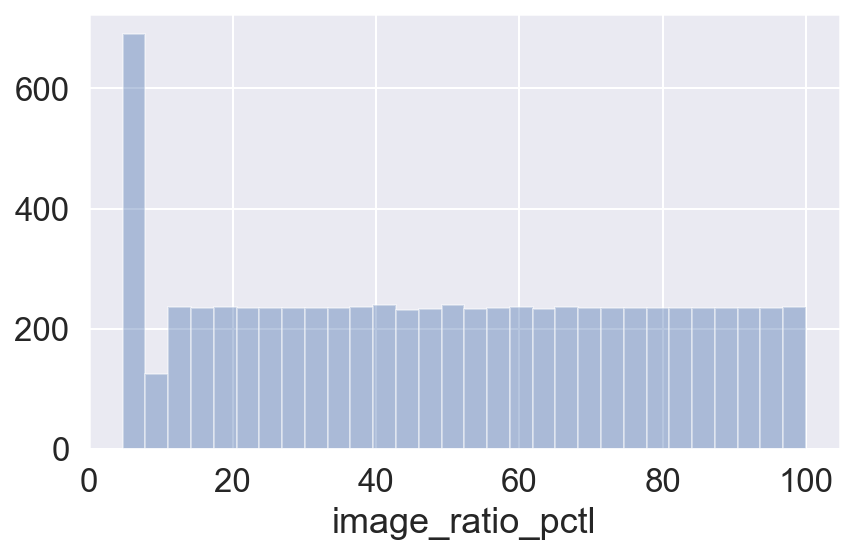

In [60]:
# Let's visualize #
sns.distplot(data.image_ratio_pctl, bins=30, kde=False);

In [61]:
# Let's use the image_ratio_percentile instead #
image_model = sm.logit("label ~ image_ratio_pctl", data=data).fit()
image_model.summary()

Optimization terminated successfully.
         Current function value: 0.692458
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7393
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 Apr 2020   Pseudo R-squ.:               0.0004832
Time:                        17:48:45   Log-Likelihood:                -5120.7
converged:                       True   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                   0.02607
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1431      0.047      3.070      0.002       0.052       0.234
image_ratio_pctl    -0.0018      0.001     -2.224      0.026      -0.003      -0.000
====================================================================================
"""

In [62]:
# Let's fit a model with the percentile and the percentile squared (quadratic effect) #
# This will let us model that inverse parabola #
image_model = sm.logit("label ~ image_ratio_pctl + np.power(image_ratio_pctl, 2)", data=data).fit()
image_model.summary()

Optimization terminated successfully.
         Current function value: 0.686094
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7392
Method:                           MLE   Df Model:                            2
Date:                Thu, 23 Apr 2020   Pseudo R-squ.:                0.009668
Time:                        17:48:45   Log-Likelihood:                -5073.7
converged:                       True   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                 3.084e-22
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3687      0.071     -5.219      0.000      -0.507      -0.230
image_ratio_pctl                  0.0289      0.003      8.808      0.000       0.022       0.035
np.power(image_ratio_pctl, 2)    -0.0003   3.18e-05     -9.644      0.000      -0.000      -0.000
=================================================================================================
"""

Given above, we can concluded that once modeled well (convert the image ratio to percentiles and include
a quadratic term), we can see significant effects:

1. There is a positive effect of the image ratio percentile score (its rank across image_ratios).

2. There is a negative quadratic effect of image ratio. That is to say, at a certain point, the squared term of image_ratio_pctl overtakes the linear term. The highest probability of evergreen sites have image ratios in the median range.

Let's try to fit a logistic regression with multiple predictors.

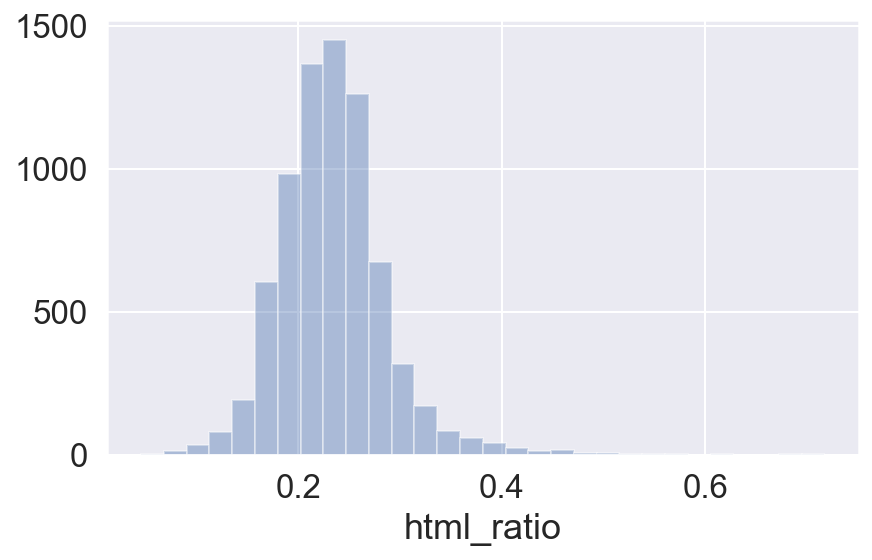

In [63]:
# Let's look at the distribution of html_ratio #
sns.distplot(data.html_ratio, bins=30, kde=False);

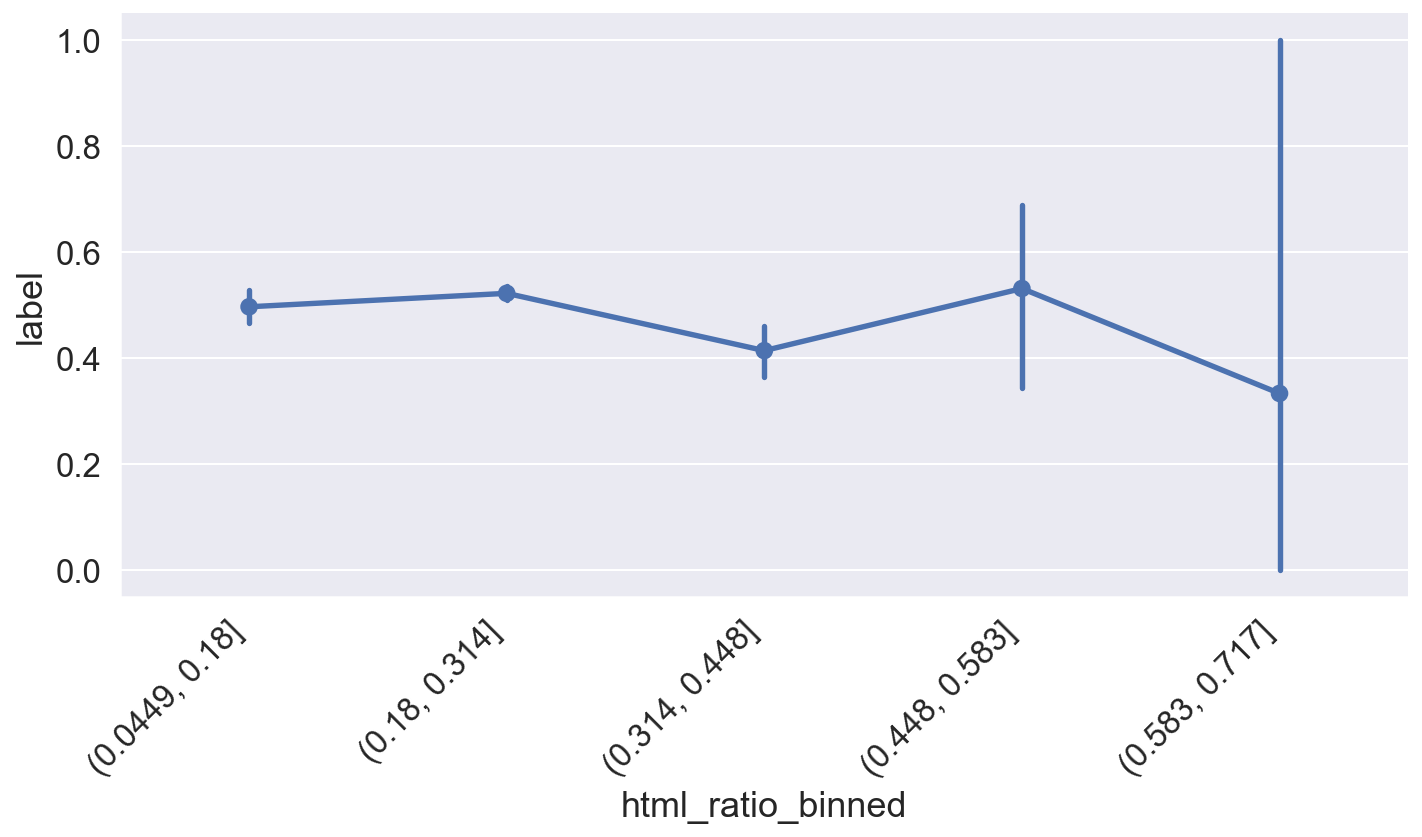

In [64]:
# Let's divide things up into linear bins #
data['html_ratio_binned'] = pd.cut(data['html_ratio'], 5)
sns.catplot('html_ratio_binned', 'label', data=data, kind='point', aspect=2).set_xticklabels(rotation=45, 
                                                                                 horizontalalignment='right');

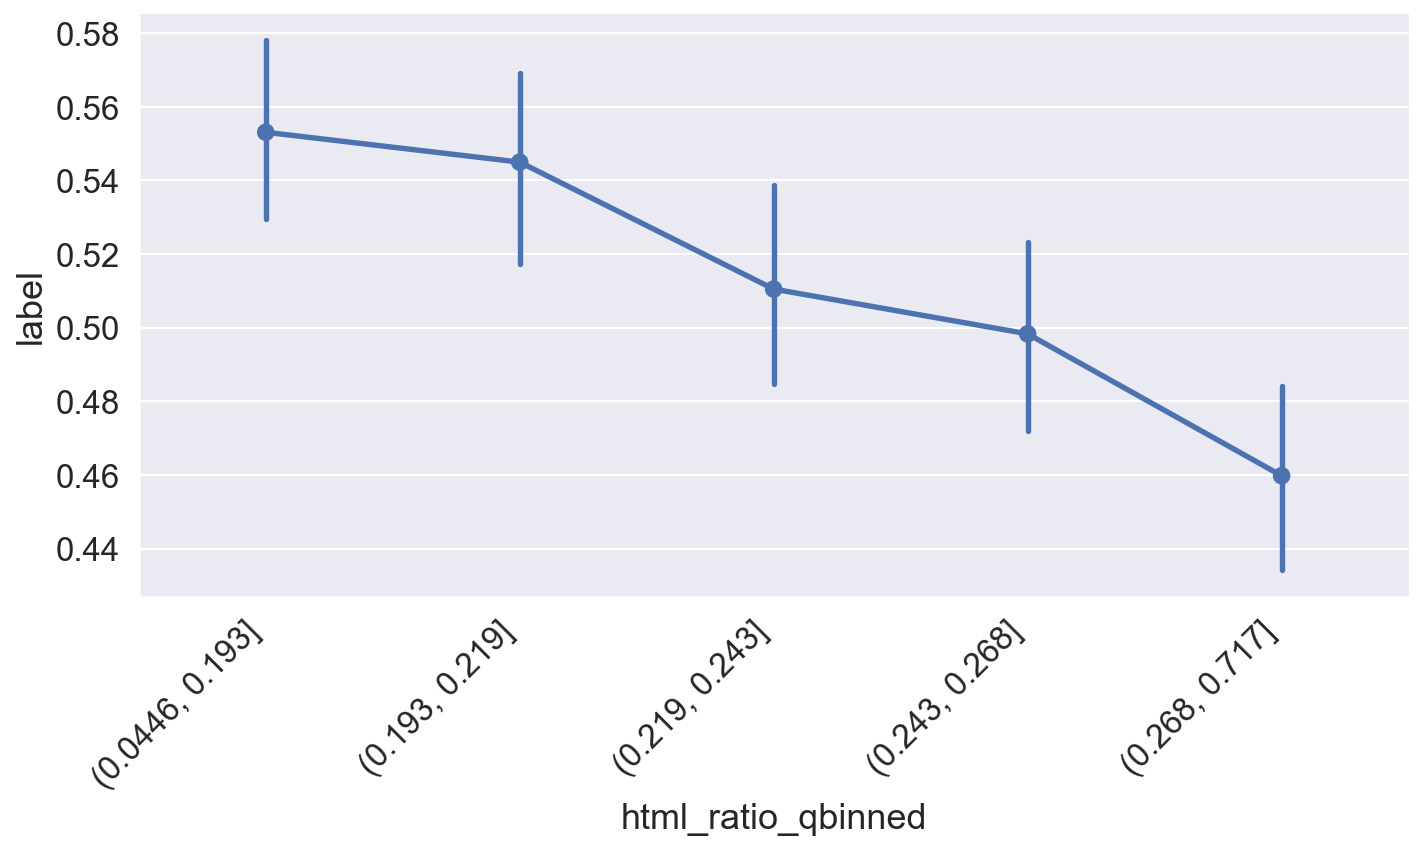

In [65]:
# Let's divide things up into linear quantile bins #
data['html_ratio_qbinned'] = pd.qcut(data['html_ratio'], 5)
sns.catplot('html_ratio_qbinned', 'label', data=data, kind='point', aspect=2).set_xticklabels(rotation=45, 
                                                                                 horizontalalignment='right');

In [66]:
# Let's set the percentiles from 0-100 (important for interpreting coefs) #
data['html_ratio_pctl'] = data.html_ratio.map(lambda x: stats.percentileofscore(data.html_ratio.values, x))

data.html_ratio_pctl.head()

0    63.029074
1    26.747803
2    46.085193
3    78.417850
4    48.275862
Name: html_ratio_pctl, dtype: float64

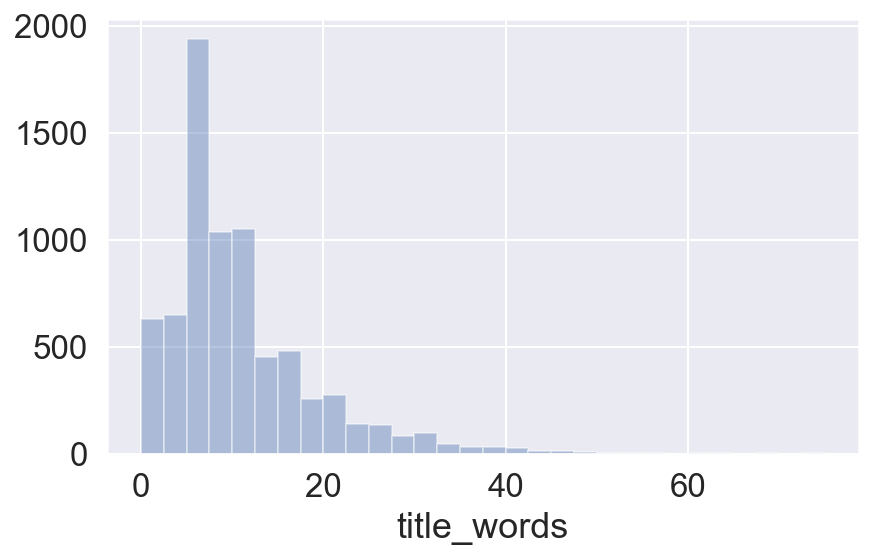

In [67]:
# Let's calculate the number of words in the title and plot the distribution #
def title_len(x):
    try:
        return len(x.split())
    except:
        return 0.

data['title_words'] = data.title.map(title_len)
sns.distplot(data.title_words, bins=30, kde=False);

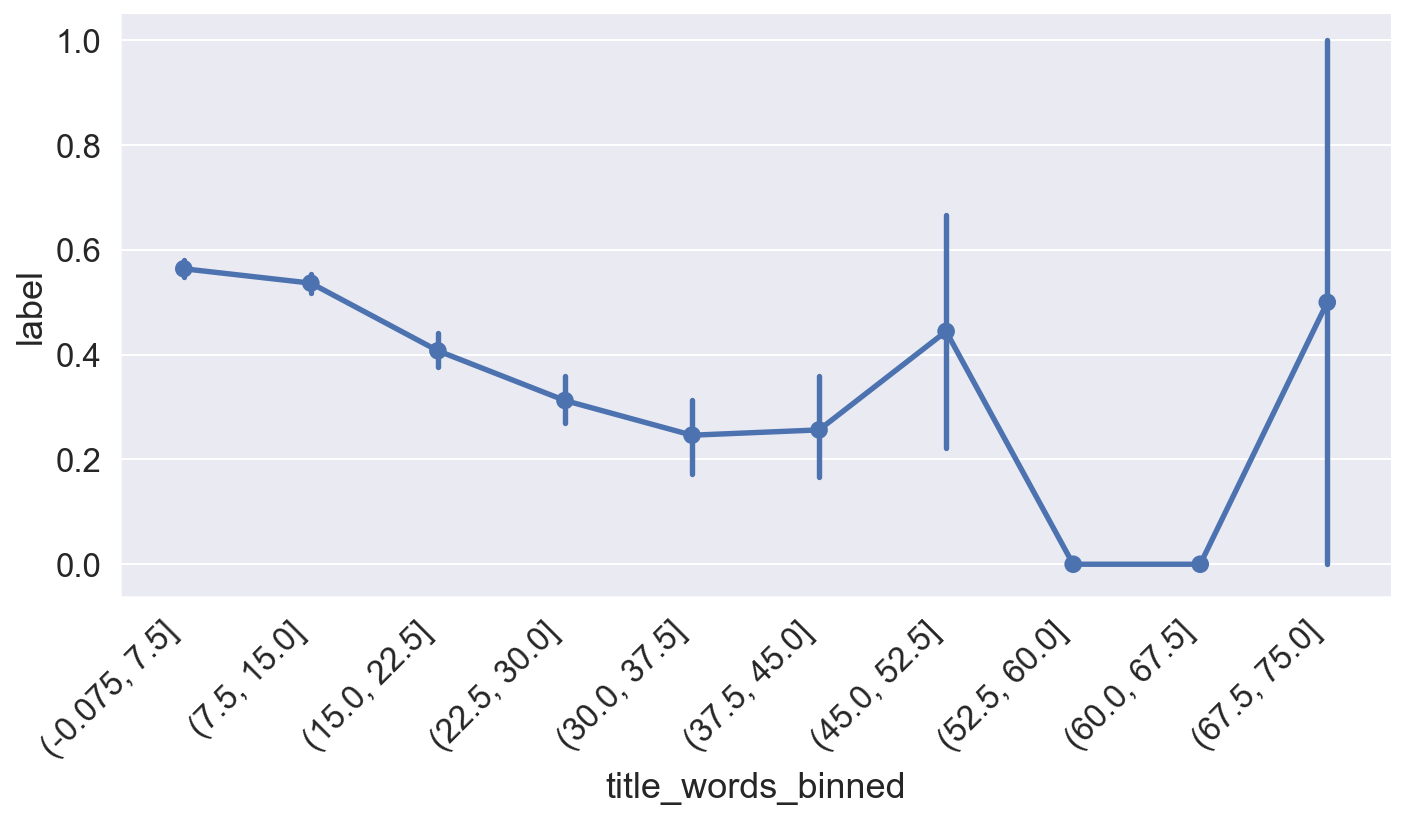

In [68]:
# Let's visualize #
data['title_words_binned'] = pd.cut(data['title_words'], 10)

sns.catplot('title_words_binned', 'label', data=data, kind='point', aspect=2).set_xticklabels(rotation=45, 
                                                                                 horizontalalignment='right');

In [69]:
# Let's build a model with the image ratio percentile, html ratio, and title length #
f = '''
label ~ image_ratio_pctl + np.power(image_ratio_pctl, 2) + html_ratio_pctl + title_words
'''
model = sm.logit(f, data=data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.667797
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7390
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Apr 2020   Pseudo R-squ.:                 0.03608
Time:                        17:48:49   Log-Likelihood:                -4938.4
converged:                       True   LL-Null:                       -5123.2
Covariance Type:            nonrobust   LLR p-value:                 9.885e-79
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.3855      0.096      4.015      0.000       0.197       0.574
image_ratio_pctl                  0.0382      0.003     11.181      0.000       0.031       0.045
np.power(image_ratio_pctl, 2)    -0.0004   3.31e-05    -12.514      0.000      -0.000      -0.000
html_ratio_pctl                  -0.0078      0.001     -8.438      0.000      -0.010      -0.006
title_words                      -0.0446      0.003    -13.928      0.000      -0.051      -0.038
=================================================================================================
"""

In [70]:
# Let's exponentiate the coefficients to get the odds ratio #
np.exp(model.params)

Intercept                        1.470349
image_ratio_pctl                 1.038888
np.power(image_ratio_pctl, 2)    0.999585
html_ratio_pctl                  0.992222
title_words                      0.956410
dtype: float64

Given above, we can concluded that we've gotten all significant effects on our predictors here. We must interpret them as odds ratios.

1. For a 1 percentile increase in image_ratio, there is a ~1.03x increase in the odds of evergreen.
2. For a 1 unit increase in (image_ratio_pctl)^2, there is a ~0.999x decrease in the odds of evergreen.
3. For a 1 percentile increase in html_ratio, there is a ~0.992x decrease in the odds of evergreen.
4. For a 1 word increase in the length of the title, there is a ~0.956x decrease in the odds of evergreen.